# Squeeze

In [1]:
import torch

data = torch.randn(3, 1)

data.dim(), data.shape, data

(2,
 torch.Size([3, 1]),
 tensor([[-0.5521],
         [ 0.6368],
         [-1.8672]]))

In [2]:
data = data.squeeze()
data.dim(), data.shape, data

(1, torch.Size([3]), tensor([-0.5521,  0.6368, -1.8672]))

In [3]:
data = torch.rand(3, 1)
data.dim(), data.shape, data

(2,
 torch.Size([3, 1]),
 tensor([[0.5608],
         [0.3645],
         [0.6161]]))

In [4]:
data = data.unsqueeze(dim=1)
data.dim(), data.shape, data

(3,
 torch.Size([3, 1, 1]),
 tensor([[[0.5608]],
 
         [[0.3645]],
 
         [[0.6161]]]))

# Reshape

In [5]:
data = torch.rand(64, 1, 28, 28)

data.dim(), data.shape

(4, torch.Size([64, 1, 28, 28]))

In [6]:
data = data.reshape(-1)

data.dim(), data.shape

(1, torch.Size([50176]))

In [7]:
data = data.reshape(-1, 784)

data.dim(), data.shape

(2, torch.Size([64, 784]))

# Normalization

## Why? See Board

In [8]:
import torch
def min_max_normalize(data: torch.Tensor) -> torch.Tensor:
    return (data - min(data)) / (max(data) - min(data))

def standardization(data: torch.Tensor) -> torch.Tensor:
    return (data - torch.mean(data)) / torch.std(data)

def log_normal(data: torch.Tensor) -> torch.Tensor:
    return torch.log(data)

def logistic_normalization(data: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-data))

# Dataset

In [9]:
from typing import Tuple, List
import os
from pathlib import Path
from PIL import Image
from torchvision.transforms import Compose
from torch.utils.data import Dataset

class CatsDogsDataset(Dataset):
    def __init__(self, root_dir: str, transform: Compose = None) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.path = list(Path(self.root_dir).glob("**/*.jpg"))
        self.transform = transform
        self.classes, self.classes_to_idx = self.__find_classes()

    def __getitem__(self, index) -> Tuple[Image.Image, int]:
        image = self.__load_image(index)
        class_name = self.__get_class(index)
        class_idx = self.classes_to_idx[class_name]
        
        if self.transform:
            image = self.transform(image)

        return image, class_idx

    def __len__(self) -> int:
        return len(self.path)

    def __find_classes(self) -> Tuple[List[str], dict]:
        classes = sorted(entry.name for entry in os.scandir(self.root_dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def __load_image(self, index: int) -> Image.Image:
        return Image.open(self.path[index]).convert("RGB")
    
    def __get_class(self, index: int) -> str:
        return self.path[index].parent.name

train_cats_dogs = CatsDogsDataset(root_dir="data/train")
test_cats_dogs = CatsDogsDataset(root_dir="data/test")

In [10]:
len(train_cats_dogs), len(test_cats_dogs)

(17999, 7000)

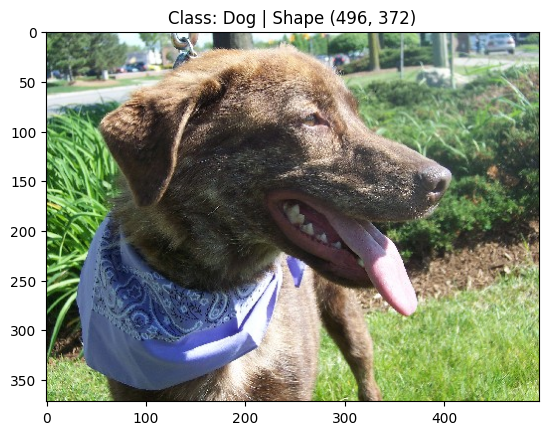

In [11]:
import random
import matplotlib.pyplot as plt
def display_random_image(
        dataset: Dataset,
        classes: List[str] = None,
):
    idx = random.sample(range(len(dataset)), k=1)
    data: Tuple[Image.Image, int] = dataset[idx[0]]
    image, target = data
    
    
    plt.imshow(image)
    plt.title(f"Class: {classes[target]} | Shape {image.size}")

display_random_image(train_cats_dogs, train_cats_dogs.classes)

# DataLoader

In [262]:
from torch.utils.data import DataLoader


train_loader = DataLoader(dataset=train_cats_dogs, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_cats_dogs, batch_size=64, shuffle=False)

print(f"Train Loader: {train_loader} | Size: {len(train_loader)}")
print(f"Test Loader: {test_loader} | Size: {len(test_loader)}")

Train Loader: <torch.utils.data.dataloader.DataLoader object at 0x2869503d0> | Size: 282
Test Loader: <torch.utils.data.dataloader.DataLoader object at 0x286849250> | Size: 110


# CNN

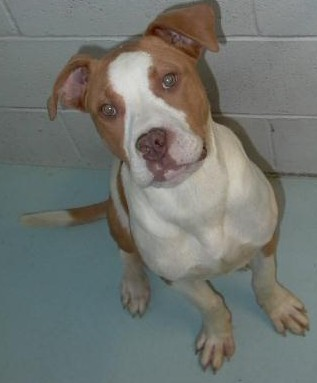

In [78]:
data: Tuple[Image.Image, int] = train_cats_dogs[16623]
image, target = data

image

In [252]:
from torch import nn
from torchvision.transforms import ToTensor, Resize
class CNNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1),
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=20*28*28, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        y = self.conv1_layer(x)
        print(y.shape)
        y = y.view(1, -1)
        print(y.shape)
        y = self.linear_layer(y)
        print(y.shape)
        return y
        

model = CNNModel()

with torch.inference_mode():
    prediction = model(ToTensor().__call__(Resize(size=(32, 32)).__call__(image)))
    prediction = prediction.argmax(dim=1)

print(f"Prediction: {prediction}")


torch.Size([3, 32, 32])
torch.Size([20, 28, 28])
torch.Size([1, 15680])
torch.Size([1, 2])
Prediction: tensor([1])


In [255]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

In [259]:
from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                